In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
from anndata import AnnData, concat
import cloudpickle

In [2]:
import jax.numpy as jnp

In [3]:
import cellrank as cr
import scvelo as scv

In [4]:
from moscot.problems.time import TemporalNeuralProblem

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [9]:
adata145 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_14.5_growth_rate.h5ad")
adata155 = sc.read("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/day_15.5_growth_rate.h5ad")
adata = concat([adata145, adata155])

In [10]:
adata.obs['day']

index
AAACCTGAGATCCCGC-1-2    14.5
AAACCTGAGCAGGTCA-1-2    14.5
AAACCTGCAATGAATG-1-2    14.5
AAACCTGCAATTGCTG-1-2    14.5
AAACCTGCACAGAGGT-1-2    14.5
                        ... 
TTTGTCAGTTGTTTGG-1-3    15.5
TTTGTCATCCTGCAGG-1-3    15.5
TTTGTCATCGAATGCT-1-3    15.5
TTTGTCATCTGTTTGT-1-3    15.5
TTTGTCATCTTAACCT-1-3    15.5
Name: day, Length: 20519, dtype: float64

In [13]:
tnp = TemporalNeuralProblem(adata)
tnp = tnp.score_genes_for_marginals("mouse", "mouse")

In [ ]:
tnp = tnp.prepare("day", joint_attr="X_pca")
tnp = tnp.solve(tau_a=0.95, tau_b=0.95)

INFO     Solving problem BirthDeathNeuralProblem[stage='prepared', shape=(9633, 10886)].                           


 17%|██████████████████████████████████████▋                                                                                                                                                                                                  | 4149/25000 [3:29:58<12:55:44,  2.23s/it]

In [ ]:
with open("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/test_save_tnp", "wb") as f:
    cloudpickle.dump(tnp, f)

tnp

In [5]:
with open("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/test_save_tnp", "rb") as f:
    tnp = cloudpickle.load(f)

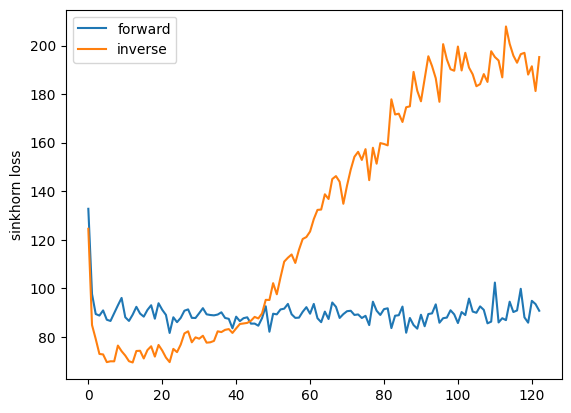

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_forward"], label="forward")
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["sinkhorn_loss_inverse"], label="inverse")
ax.set_ylabel("sinkhorn loss")
ax.legend()
plt.show()

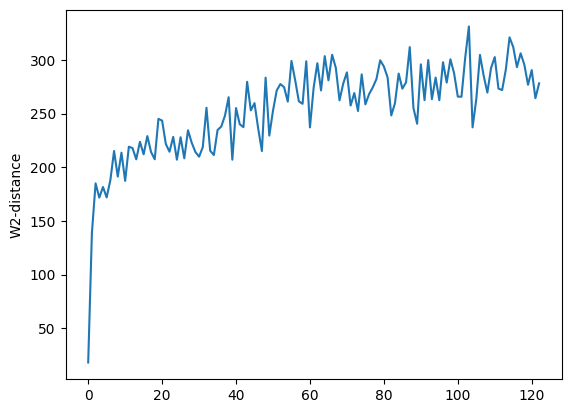

In [7]:
fig, ax = plt.subplots()
ax.plot(tnp[14.5, 15.5].solution._training_logs["valid_logs"]["valid_w_dist"])
ax.set_ylabel("W2-distance")
plt.show()

In [11]:
source = jnp.array(adata.obsm["X_pca"].copy())

In [12]:
velocity = tnp[14.5, 15.5].solution.push(source) - source

In [13]:
adata_result = AnnData(shape=velocity.shape)
adata_result.obs = adata.obs.copy()

In [14]:
adata_result.layers["GEX_velocity"] = np.asarray(velocity)
adata_result.layers["X_pca"] = np.asarray(adata.obsm["X_pca"])

In [15]:
adata_result

AnnData object with n_obs × n_vars = 20519 × 50
    obs: 'day', 'n_counts', 'log_counts', 'n_genes', 'mt_frac', 'proliferation', 'G2M_score', 'S_score', 'clusters_fig3_final', 'clusters_fig3_final_noep', 'clusters_fig4_final', 'clusters_fig2_final', 'clusters_fig6_broad_final', 'clusters_fig6_fine_final', 'clusters_fig6_alpha_final', 'celltype', 'prolif', 'apoptosis', 'growth_rate', 'scaled_growth_rate', 'scaled3_growth_rate', 'scaled4_growth_rate'
    layers: 'GEX_velocity', 'X_pca'

In [16]:
adata_result.write("/lustre/groups/ml01/workspace/monge_velo/data/benchmarks/pancreas/adata_gex_velocities.h5ad")